# Pipeline

In [164]:
from darts import TimeSeries
from datetime import datetime

from dateutil.parser import parse
from matplotlib.pylab import rcParams
from tqdm import tqdm_notebook as tqdm
from statsmodels.tsa.stattools import adfuller
from torch.utils.tensorboard import SummaryWriter
from darts.utils.statistics import check_seasonality, plot_acf

import os
import torch
import shutil
import warnings
import itertools
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import statsmodels.api as sm
from darts.metrics import mape
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


%matplotlib inline
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 15, 5

### 1. Data Load

- TAG와 상관관계가 낮은 MELT_WEIGHT의 경우 제거

In [165]:
df = pd.read_csv('./public/data/raw_data.csv')

df['TAG'] = df['TAG'] == 'NG'

df.index = pd.date_range(start='3/4/2020', end='5/1/2020', freq='6S')[:-1]

df.drop(columns='STD_DT', inplace=True)
df.drop(columns='NUM', inplace=True)
df.drop(columns='MELT_WEIGHT', inplace=True)

df = df.astype(np.float32)
df['TAG'] = df['TAG'].astype(bool)

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 835200 entries, 2020-03-04 00:00:00 to 2020-04-30 23:59:54
Freq: 6S
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   MELT_TEMP   835200 non-null  float32
 1   MOTORSPEED  835200 non-null  float32
 2   INSP        835200 non-null  float32
 3   TAG         835200 non-null  bool   
dtypes: bool(1), float32(3)
memory usage: 16.7 MB


,MELT_TEMP,MOTORSPEED,INSP
count,835200.000000,835200.000000,835200.000000
mean,509.200714,459.783020,3.194854
std,128.277512,639.436401,0.011822
min,308.000000,0.000000,3.170000
25%,430.000000,119.000000,3.190000
50%,469.000000,168.000000,3.190000
75%,502.000000,218.000000,3.200000
max,832.000000,1804.000000,3.230000


### 2. Data 분리

- Base 모델 학습 시 3월 달의 데이터만 사용

In [166]:
seened_index = (df.index.month == 3) | ((df.index.month == 4) & (df.index.day <= 10))

seened_df = df[seened_index]
real_time_df = df[~seened_index]

### 3. 2-stage AD의 첫번째 Stage인 PCA 훈련

In [167]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

x = seened_df.drop(['TAG'], axis=1).values
y = seened_df['TAG'].values
pca_scaler = StandardScaler()
x = pca_scaler.fit_transform(x)

pca = PCA(n_components=2)
printcipal_components = pca.fit_transform(x)
principal_df = pd.DataFrame(
    data=printcipal_components,
    columns=['pc1', 'pc2']
) 
principal_df['TAG'] = y

,pc1,pc2,TAG


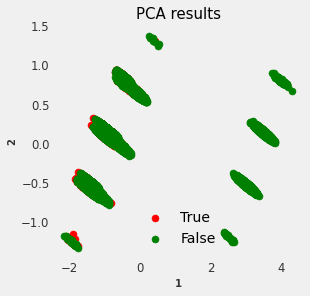

In [168]:
fig = plt.figure(figsize = (4, 4))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('1', fontsize = 10)
ax.set_ylabel('2', fontsize = 10)
ax.set_title('PCA results', fontsize=15)

targets = [True, False]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = principal_df['TAG'] == target
    ax.scatter(
        principal_df.loc[indicesToKeep, 'pc1'],
        principal_df.loc[indicesToKeep, 'pc2'],
        c = color,
        s = 50
    )
ax.legend(targets)
ax.grid()

principal_df[(principal_df['pc1'] >= 0.5) & (principal_df['TAG'] == True)]

### 4. Base 모델 학습 (3월달 데이터로만 학습)

In [169]:
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler

scaler = Scaler(scaler=MinMaxScaler())

seened_x_df = seened_df.copy(False)
seened_y_df = pd.DataFrame(
    seened_x_df.pop('TAG'),
    columns=['TAG']
)

real_time_x_df = real_time_df.copy(False)
real_time_y_df = pd.DataFrame(
    real_time_x_df.pop('TAG'),
    columns=['TAG']
)

total_x_df = df.copy(False)
total_y_df = pd.DataFrame(
    total_x_df.pop('TAG'),
    columns=['TAG']
)

In [170]:
seened_x_series = TimeSeries.from_dataframe(
    seened_x_df, freq='6S', fill_missing_dates=True
)

seened_y_series = TimeSeries.from_dataframe(
    seened_y_df, freq='6S', fill_missing_dates=True
)

real_time_x_series = TimeSeries.from_dataframe(
    real_time_x_df, freq='6S', fill_missing_dates=True
)

real_time_y_series = TimeSeries.from_dataframe(
    real_time_y_df, freq='6S', fill_missing_dates=True
)

total_x_series = TimeSeries.from_dataframe(
    total_x_df, freq='6S', fill_missing_dates=True
)

total_y_series = TimeSeries.from_dataframe(
    total_y_df, freq='6S', fill_missing_dates=True
)

seened_scaled = scaler.fit_transform(seened_x_series)
real_time_scaled = scaler.transform(real_time_x_series)
total_scaled = scaler.transform(total_x_series)

seened_scaled = seened_scaled.astype(np.float32)
real_time_scaled = real_time_scaled.astype(np.float32)
total_scaled = total_scaled.astype(np.float32)

In [173]:
from darts.models import TransformerModel

import torch.nn as nn

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

from darts.models import TransformerModel

model_name = 'transformer'
epoch = 10

ensemble_models = [
    TransformerModel(
        input_chunk_length=window_size,
        output_chunk_length=1,
        batch_size=256,
        dropout=0.05,
        d_model=16,
        nhead=8,
        num_encoder_layers=2,
        num_decoder_layers=2,
        dim_feedforward=128,
        loss_fn=RMSELoss(),
        model_name=model_name,
        random_state=42,
        pl_trainer_kwargs={
            "accelerator": "gpu",
            "devices": [0]
        }
    )
    # 모델 추가
]

for i, model in enumerate(ensemble_models):
    ensemble_models[i] = model.load(f'./models/{model.model_name}/{model.model_name}.pt')

### 5. 실시간 추론

In [174]:
def predict(model, n, index):
    pred = model.predict(n=n, series=total_scaled[:index])
    return pred

def predict_with_data(model, n, data):
    pred = model.predict(n=n, series=data)
    return pred

In [240]:
def detect_classify_anomalies(reals, preds, labels):
    res = pd.DataFrame()

    error = (reals - preds).values().reshape(-1, 3)
    error[:, 2] = 0
    error = np.sum(error, axis=1)

    res['error'] = error
    labels = labels.values().squeeze()
    
    res['mean'] = mean = np.mean(error, axis=0)
    res['std'] = standard = np.std(error, axis=0)

    for i in [-2, -1.25, -0.75, 0.75, 1.25, 2]:
        s = mean + (i * standard)
        res[f'{i}s'] = s

    cut_list = res.loc[:, ['error', '-2s', '-1.25s', '-0.75s', 'mean', '0.75s', '1.25s', '2s']]
    cut_values = cut_list.values
    cut_sort = np.sort(cut_values)

    res['impact'] = [(lambda x: np.where(cut_sort == res['error'][x])[1][0])(x) for x in range(len(res['error']))]
    severity = {0: 3, 1: 2, 2: 1, 3: 0, 4: 0, 5: 1, 6: 2, 7: 3}
    res['color'] =  res['impact'].map(severity)
    res['predict'] = res['color'] > 0
    res.drop(columns=['impact', 'std'], inplace=True)
    res['labels'] = labels == 1
    return res

In [241]:
window_size = 20

x = seened_scaled[:-50]
reals = seened_scaled[-50:]
labels = seened_y_series[-50:]
preds = predict_with_data(ensemble_models[0], 50, x)


2022-11-04 16:07:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [242]:
res = detect_classify_anomalies(reals, preds, labels)

res

,error,mean,-2s,-1.25s,-0.75s,0.75s,1.25s,2s,color,predict,labels
0,0.081521,0.015816,-0.090333,-0.050527,-0.02399,0.055621,0.082158,0.121964,1,True,False
1,0.046850,0.015816,-0.090333,-0.050527,-0.02399,0.055621,0.082158,0.121964,0,False,True
2,-0.059155,0.015816,-0.090333,-0.050527,-0.02399,0.055621,0.082158,0.121964,2,True,True
3,0.054699,0.015816,-0.090333,-0.050527,-0.02399,0.055621,0.082158,0.121964,0,False,True
4,-0.035085,0.015816,-0.090333,-0.050527,-0.02399,0.055621,0.082158,0.121964,1,True,False
5,0.014940,0.015816,-0.090333,-0.050527,-0.02399,0.055621,0.082158,0.121964,0,False,False
6,0.008337,0.015816,-0.090333,-0.050527,-0.02399,0.055621,0.082158,0.121964,0,False,False
7,0.032107,0.015816,-0.090333,-0.050527,-0.02399,0.055621,0.082158,0.121964,0,False,False
8,0.061346,0.015816,-0.090333,-0.050527,-0.02399,0.055621,0.082158,0.121964,1,True,True
9,0.034892,0.015816,-0.090333,-0.050527,-0.02399,0.055621,0.082158,0.121964,0,False,False


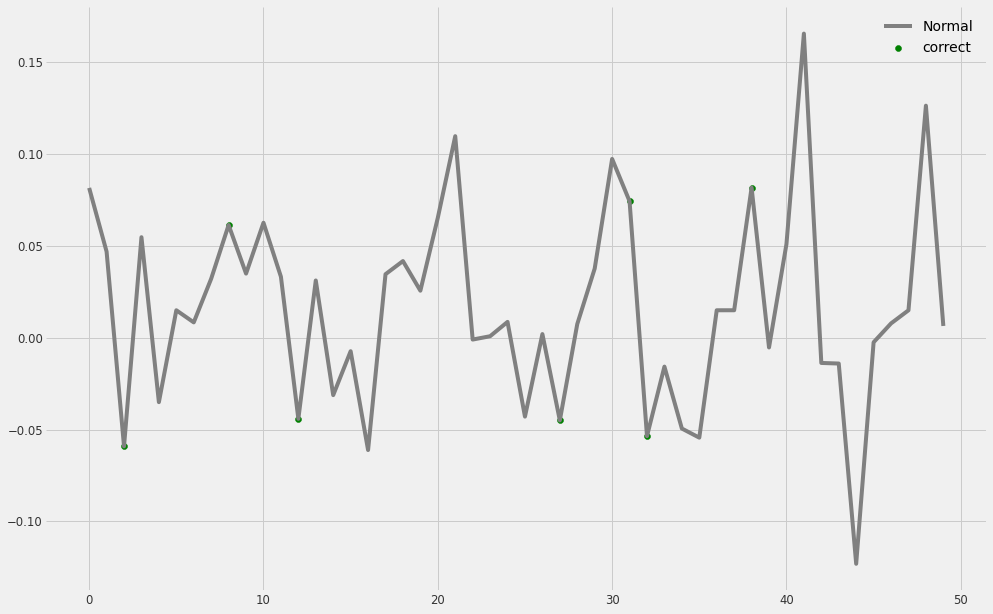

In [244]:
col = 'INSP'

fig, ax = plt.subplots(figsize=(15, 10))

# a = res.loc[res['labels'] == True, ['error']]
# b = res.loc[res['predict'] == True, ['error']]
c = res.loc[(res['predict'] == True) & (res['labels'] == True), ['error']]

# ax.scatter(a.index, a['error'], color='red', label='answer')
# ax.scatter(b.index, b['error'], color='blue', label='predict')
ax.scatter(c.index, c['error'], color='green', label='correct')
ax.plot(res.index, res['error'], color='grey', label='Normal')

plt.legend()
plt.show()